In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objs as go
from ipywidgets import interact
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

In [3]:
folder = '.'

In [4]:
shape = tuple(np.loadtxt(join(folder, 'a5d_new_shape.txt')).astype(int))
shape

(36, 57, 36, 74, 98)

In [5]:
coords = utils.load_stacked_arrays('coords.npz')
for c in coords:
    print(c.shape)

(36,)
(57,)
(36,)
(74,)
(98,)


In [6]:
for c in coords:
    print(c)

[-8.79636364 -8.29371429 -7.79106494 -7.28841558 -6.78576623 -6.28311688
 -5.78046753 -5.27781818 -4.77516883 -4.27251948 -3.76987013 -3.26722078
 -2.76457143 -2.26192208 -1.75927273 -1.25662338 -0.75397403 -0.25132468
  0.25132468  0.75397403  1.25662338  1.75927273  2.26192208  2.76457143
  3.26722078  3.76987013  4.27251948  4.77516883  5.27781818  5.78046753
  6.28311688  6.78576623  7.28841558  7.79106494  8.29371429  8.79636364]
[-2.57681998e+01 -2.48479070e+01 -2.39276141e+01 -2.30073213e+01
 -2.20870284e+01 -2.11667356e+01 -2.02464427e+01 -1.93261499e+01
 -1.84058570e+01 -1.74855642e+01 -1.65652713e+01 -1.56449785e+01
 -1.47246856e+01 -1.38043928e+01 -1.28840999e+01 -1.19638071e+01
 -1.10435142e+01 -1.01232214e+01 -9.20292851e+00 -8.28263566e+00
 -7.36234281e+00 -6.44204996e+00 -5.52175711e+00 -4.60146425e+00
 -3.68117140e+00 -2.76087855e+00 -1.84058570e+00 -9.20292851e-01
 -3.46034312e-12  9.20292851e-01  1.84058570e+00  2.76087855e+00
  3.68117140e+00  4.60146425e+00  5.52175

In [7]:
f = np.memmap(join(folder, 'a5d_new.mmp'), shape=shape, dtype='float', mode='r')

In [8]:
f.shape

(36, 57, 36, 74, 98)

In [9]:
f = np.clip(f, 0.0, None)

In [19]:
dims = ["x [mm]", "xp [mrad]", "y [mm]", "yp [mrad]", "w [MeV]"]

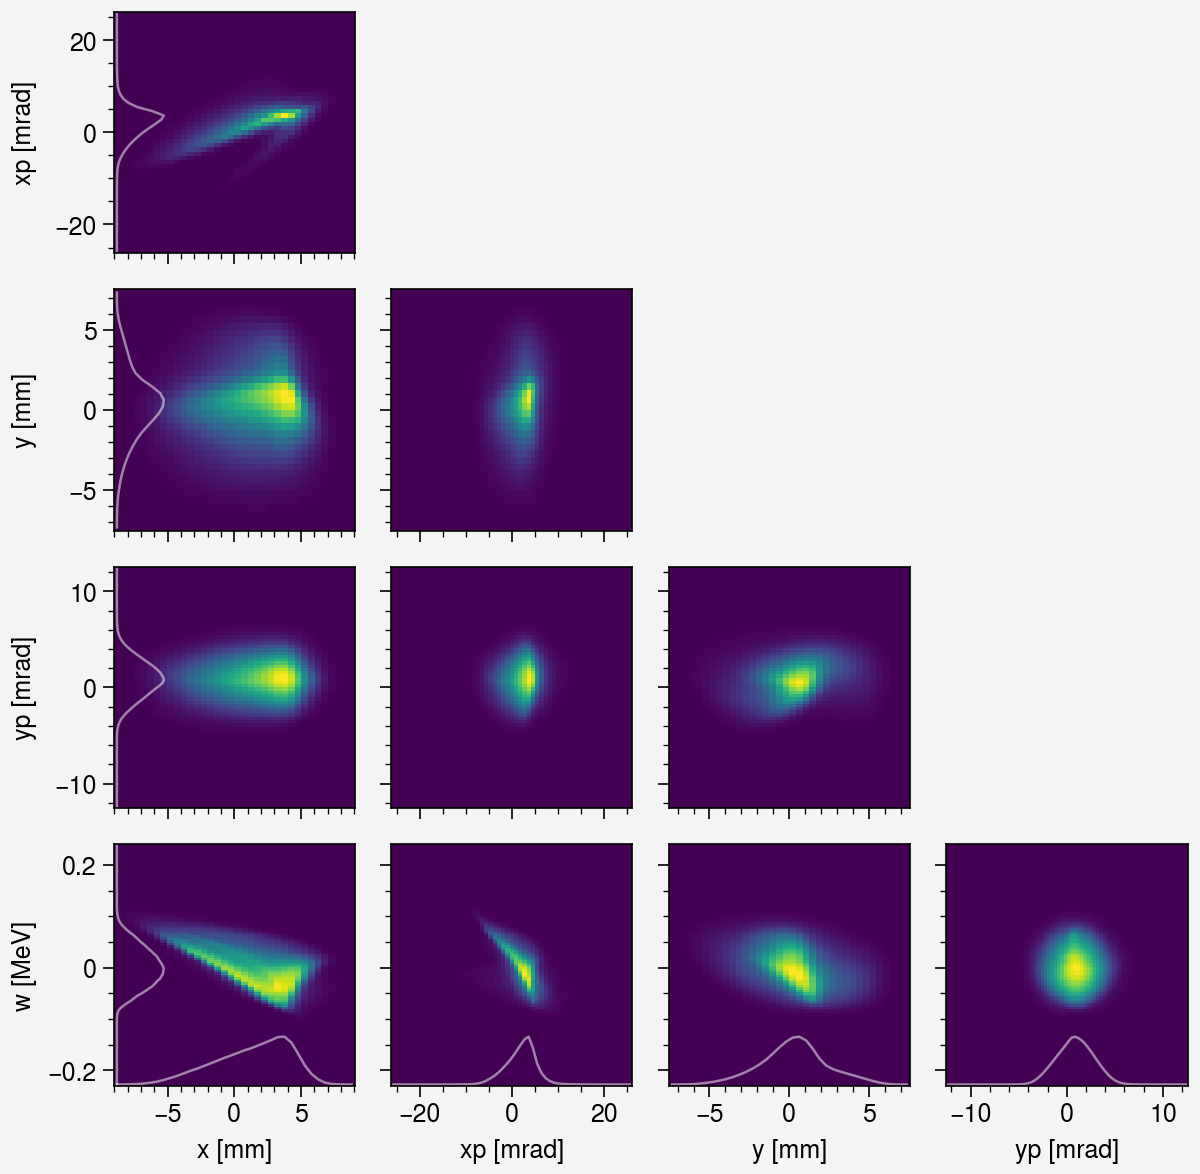

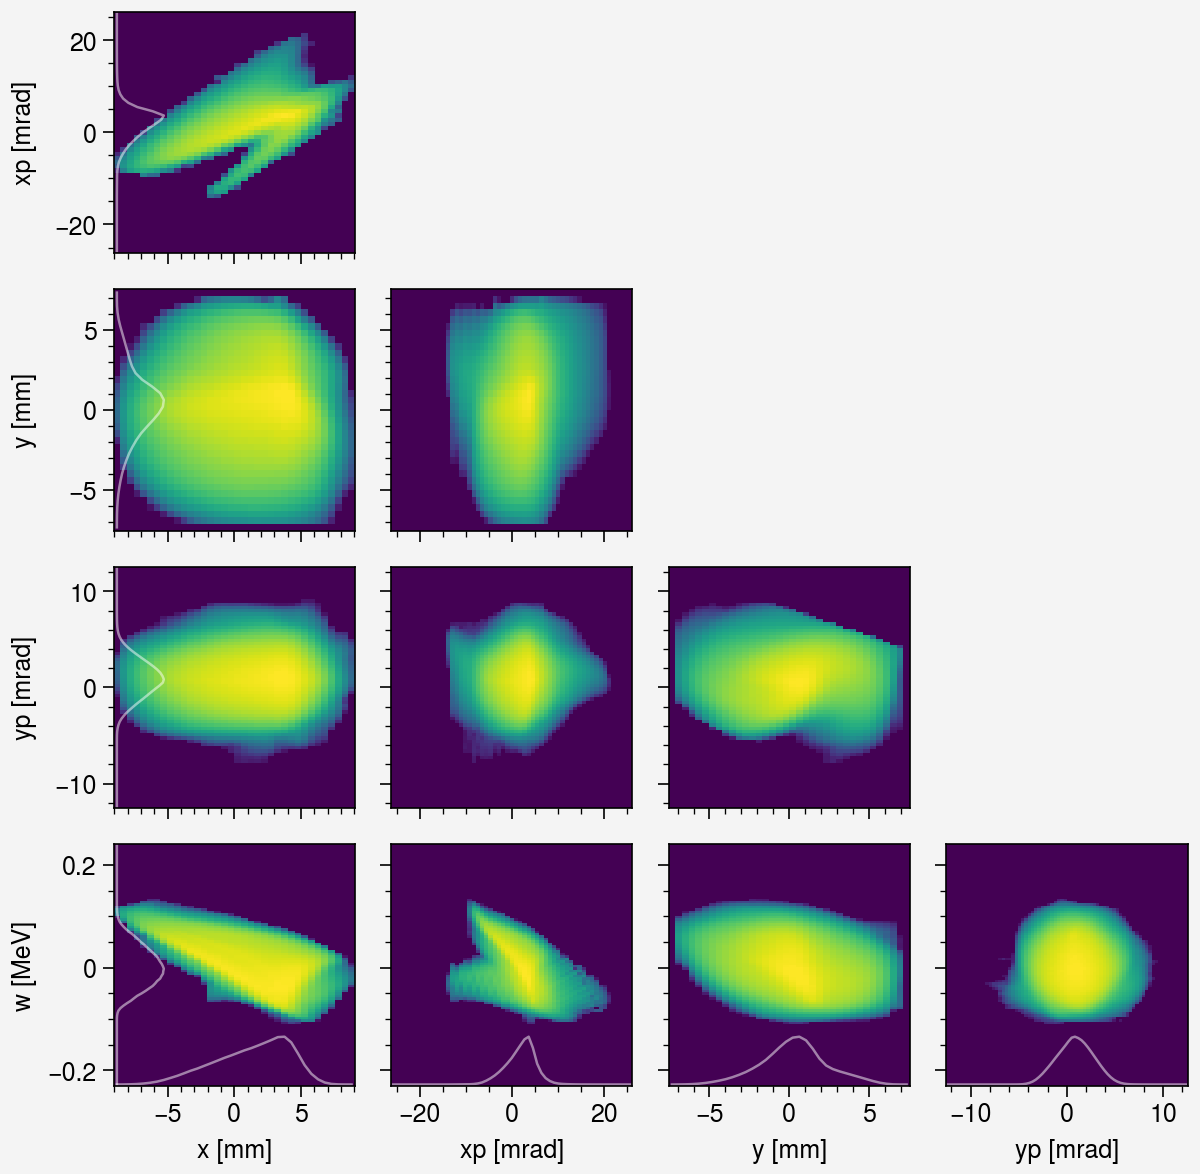

In [42]:
for norm in [None, 'log']:
    axes = mplt.corner(
        f[:, :, :, :, ::-1],
        coords=coords,
        fig_kws=dict(figwidth=1.5*4),
        diag_kind='None',
        prof='edges',
        prof_kws=dict(alpha=0.5, lw=0.9),
        labels=dims,
        norm=norm,
        frac_thresh=1e-6,
    )
    plt.savefig(f'_output/corner_int_norm{norm}.png')
    plt.show()

In [15]:
ind = np.unravel_index(np.argmax(f), f.shape)
ind = tuple([i for i in ind])
print(ind)

(25, 33, 21, 39, 63)


In [30]:
_dims = ["x", "xp", "y", "yp", "w"]
_units = ["mm", "mrad", "mm", "mrad", "MeV"]

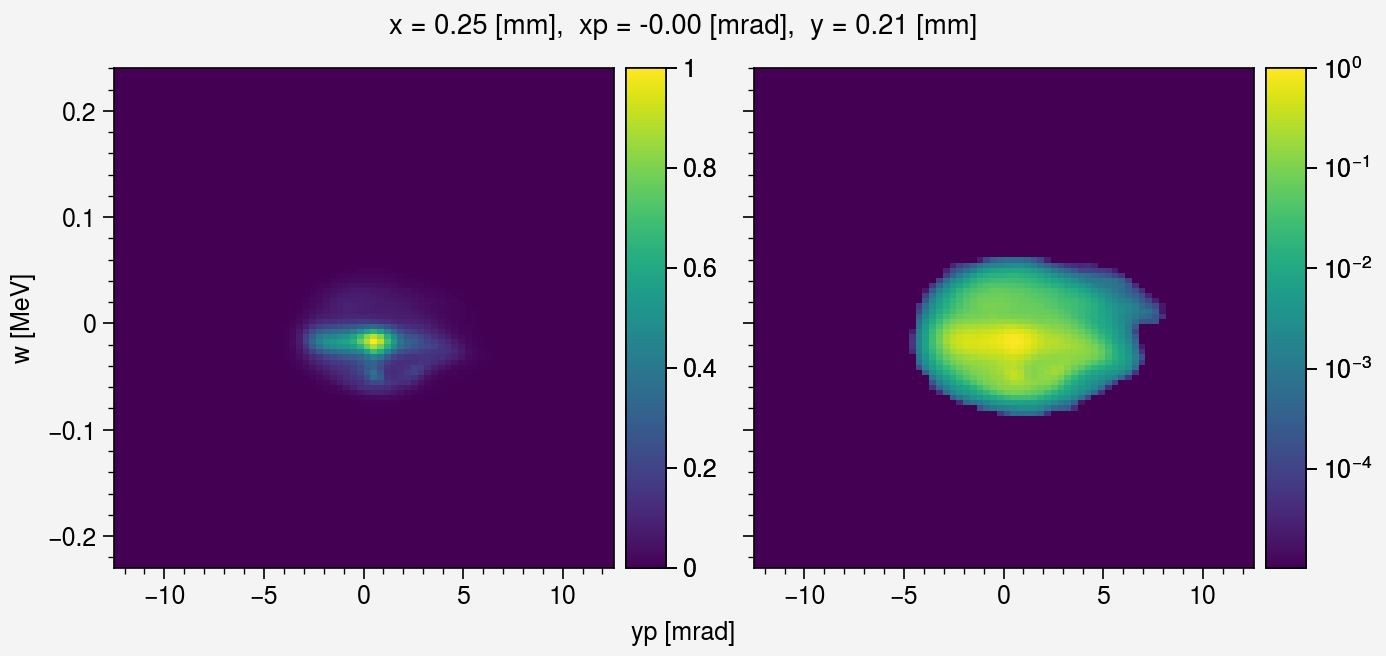

IndexError: index 3 is out of bounds for axis 0 with size 3

In [40]:
frac_thresh = 1e-5
axes_slice = [(k, j, i) for i in range(f.ndim) for j in range(i) for k in range(j)]
axes_view = [tuple([i for i in range(f.ndim) if i not in axis])
             for axis in axes_slice]
for axis, axis_view in zip(axes_slice, axes_view):
    idx = utils.make_slice(5, axis, [ind[i] for i in axis])
    f_slice = f[idx]
    f_slice = f_slice / np.max(f_slice)
    
    dim1, dim2 = [dims[i] for i in axis_view]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(f_slice, x=coords[axis_view[0]], y=coords[axis_view[1]], ax=ax, frac_thresh=frac_thresh, norm=norm, colorbar=True)
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    string = '_output/slice_'
    for i in axis:
        string += f'{_dims[i]}-{ind[i]}'
    __dims = [_dims[i] for i in axis]
    __units = [_units[i] for i in axis]
    _vals = [coords[i][ind[i]] for i in axis]
    plot_axes.format(suptitle=f'{__dims[0]} = {_vals[0]:.2f} [{__units[0]}],  {__dims[1]} = {_vals[1]:.2f} [{__units[1]}],  {__dims[2]} = {_vals[2]:.2f} [{__units[2]}]')
    plot_axes.format(suptitle_kw=dict(fontweight='normal'))
    plt.savefig(string + '.png')
    plt.show()

In [33]:
shape

(36, 57, 36, 74, 98)